# Lab: Missing data {#sec-pandas-transforming-data}

In these exercises, we have provided "good" datasets where data is properly structured in rows and columns, there's no missing data, or mixed types... Unfortunately, in real-world cases this may not be as common as we may think of. One of the main issues we may encounter is that some data may be missing. 

This can be due to a number of reasons i.e., because the measurements failed during a specific period of time, because criteria changed... and the implications of this can be serious depending on the proportion of missing data and how we deal with it. Unfortunately there's not a single, correct way of dealing with missing data: some times we may want to get rid of them if they are anecdotal, sometimes we may want to infer their values based on existing data...

In this notebook we will be working with a modified version of the _The Office_ dataset that we have been using, where some values have been removed.


## Assessing Missing values

In this case we will be reading the modified dataset stored in `office_ratings_missing.csv` where some values have been removed. The first thing we may want to do is to know where and how many of those values have been removed to inform what to do next with them.

In [1]:
import pandas as pd
df = pd.read_csv('data/raw/office_ratings_missing.csv', encoding = 'UTF-8')

In [2]:
df.head()

,season,episode,title,imdb_rating,total_votes,air_date
0,1,1,Pilot,7.6,NaN,24/03/2005
1,1,2,Diversity Day,8.3,3566.0,29/03/2005
2,1,3,Health Care,7.9,2983.0,05/04/2005
3,1,4,The Alliance,8.1,2886.0,12/04/2005
4,1,5,Basketball,8.4,3179.0,19/04/2005


Did you notice something weird on the row number 1?


::: callout-important

### Storing missing values

At this stage, it is important to understand how Python stores missing values. For python, any missing data will be represented as any of these values: `NaN` (Not a Number), `NA` (Not Available) or `None`. This is to differenciate that with cases where we may see a "gap" in the dataframe that may look like a missing data, but it is an empty string instead (`""`) or a string with a white space (`" "`). These are not considered empty values.

:::


Regretfully, exploring the head or the tail of the dataframe may not be a good idea, especially in large datasets. We may want to use `info` instead:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       188 non-null    int64  
 1   episode      188 non-null    int64  
 2   title        188 non-null    object 
 3   imdb_rating  170 non-null    float64
 4   total_votes  168 non-null    float64
 5   air_date     188 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 8.9+ KB


We are missing values in our `imdb_rating` and `total_votes` columns. Now, we need to know how many values are missing. We can do that in multiple ways. One is to combine the method `.isna` , which returns either `True` (`1`) or `False` (`2`), and then sum the values that are true (and thus, are null):

In [4]:
# Count missing values
df.isna().sum()

season          0
episode         0
title           0
imdb_rating    18
total_votes    20
air_date        0
dtype: int64

Another method is to get the maximum possible values and substract the sum of existing values:

In [5]:
# Count missing values
df.shape[0] - df.count()

season          0
episode         0
title           0
imdb_rating    18
total_votes    20
air_date        0
dtype: int64

Now we have an understanding of where the issues are and how many are there. Now the question is: _What to do with missing data?_ 

## Inputting values

A quick solution is to replace missing values with either `0 ` or give them a roughtly central value (the mean). 

To do this we use the `fillna` method, which _fills_ any missing values (`NA` -Not Available or `NaN` )

In [6]:
df['imdb_rating_with_0'] = df['imdb_rating'].fillna(0)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   season              188 non-null    int64  
 1   episode             188 non-null    int64  
 2   title               188 non-null    object 
 3   imdb_rating         170 non-null    float64
 4   total_votes         168 non-null    float64
 5   air_date            188 non-null    object 
 6   imdb_rating_with_0  188 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 10.4+ KB


This worked! `imdb_rating_with_0` does not have any missing value. However, we are significantly altering some statistical values:



In [7]:
df[['imdb_rating', 'imdb_rating_with_0']].describe()

,imdb_rating,imdb_rating_with_0
count,170.000000,188.000000
mean,8.261176,7.470213
std,0.514084,2.485781
min,6.800000,0.000000
25%,7.900000,7.800000
50%,8.200000,8.200000
75%,8.600000,8.500000
max,9.700000,9.700000


In order to try to avoid that, we can fill them with the mean:

In [8]:
df['imdb_rating_with_mean'] = df['imdb_rating'].fillna(df['imdb_rating'].mean())

df[['imdb_rating', 'imdb_rating_with_0', 'imdb_rating_with_mean']].describe()

,imdb_rating,imdb_rating_with_0,imdb_rating_with_mean
count,170.000000,188.000000,188.000000
mean,8.261176,7.470213,8.261176
std,0.514084,2.485781,0.488716
min,6.800000,0.000000,6.800000
25%,7.900000,7.800000,8.000000
50%,8.200000,8.200000,8.261176
75%,8.600000,8.500000,8.500000
max,9.700000,9.700000,9.700000


We can plot these to see what looks most reasonable (you can probably also make an educated guess here).

<Axes: >

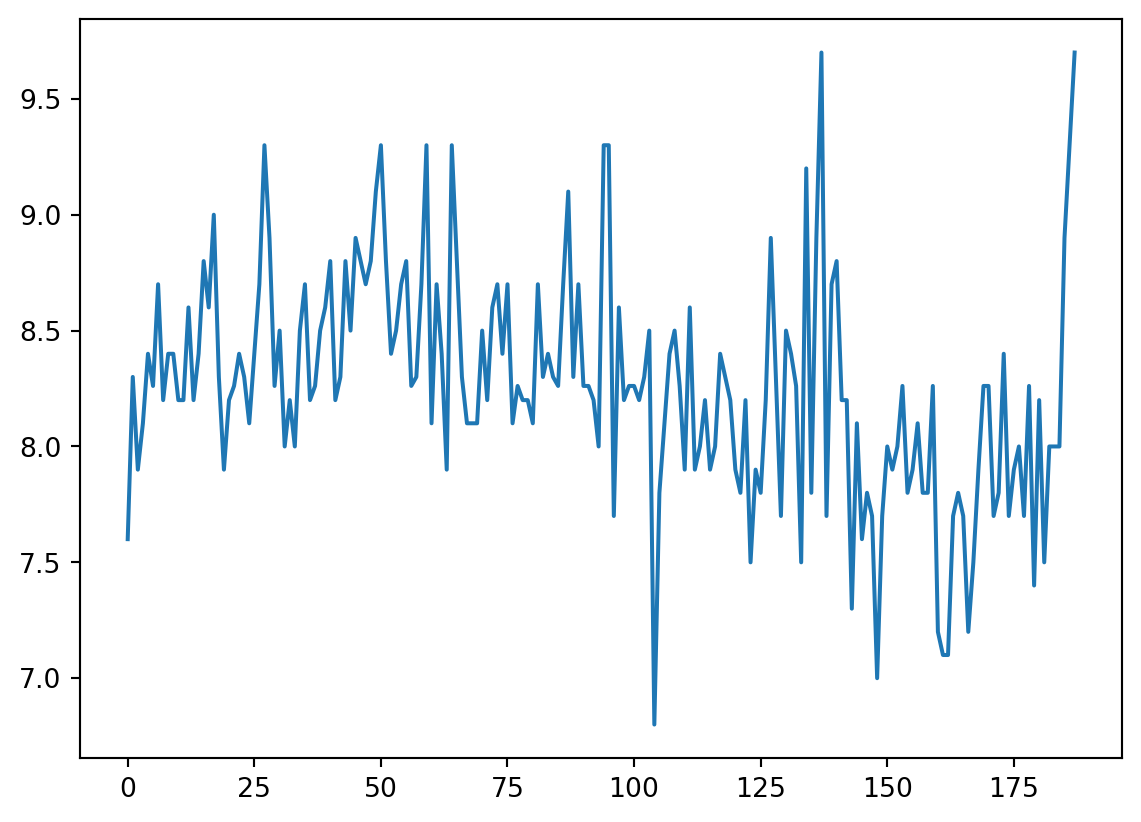

In [9]:
df['imdb_rating_with_mean'].plot()

<Axes: >

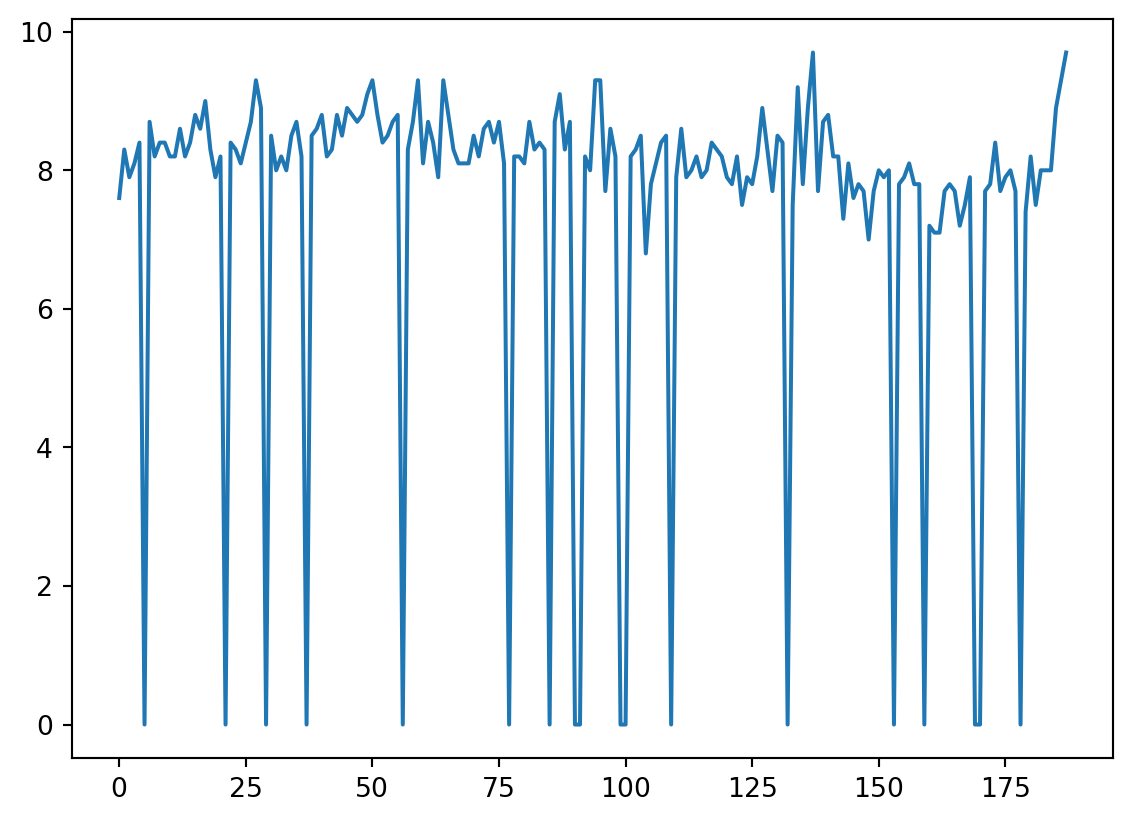

In [10]:
df['imdb_rating_with_0'].plot()

Going with the mean seems quite sensible in this case. Especially as the data is gaussian so the mean is probably an accurate represenation of the central value.

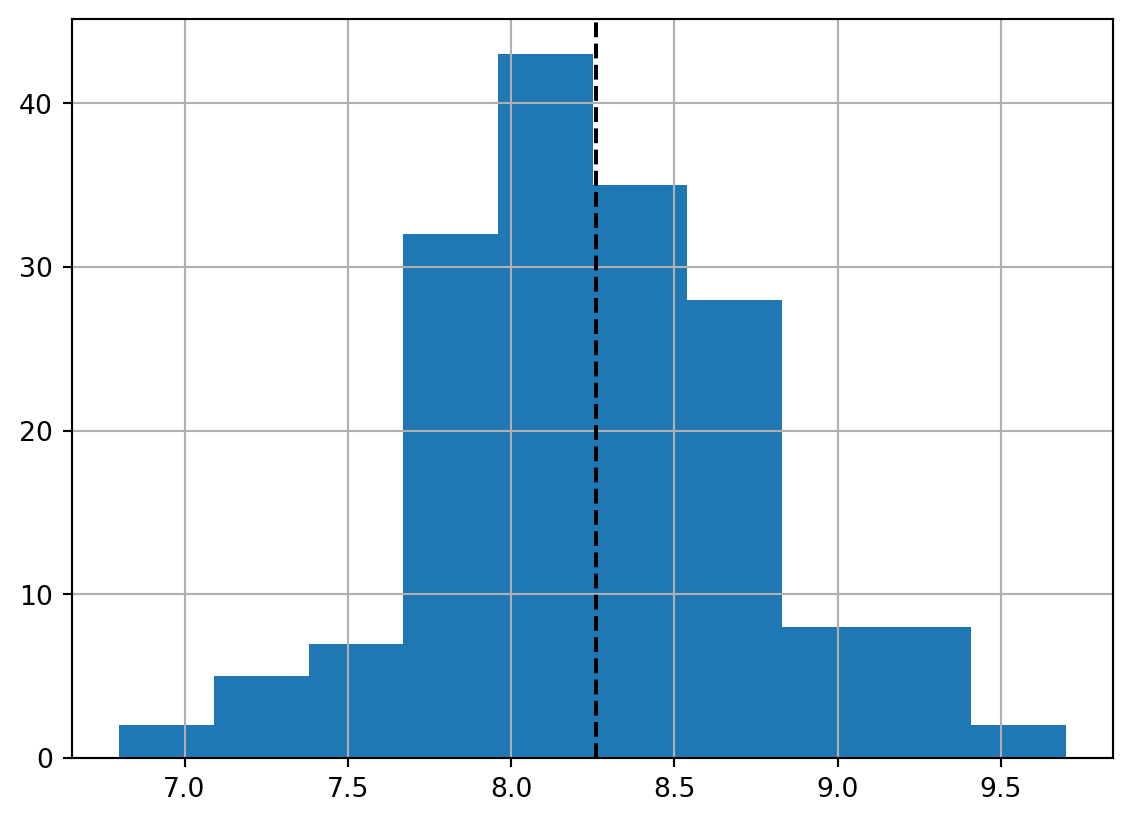

In [11]:
# Create a histogram
ax = df['imdb_rating'].hist()
# Plot the histogram and add a vertical line on the mean
ax.axvline(df['imdb_rating'].mean(), color='k', linestyle='--')

## Transformations

Some statistical models, such as standard linear regression, require the predicted variable to be gaussian distributed (a single central point and a roughly symmetrical decrease in frequency, see [this Wolfram alpha page](https://www.wolframalpha.com/input/?i=gaussian+0+1).

The distribution of votes is positively skewed (most values are low).

<Axes: >

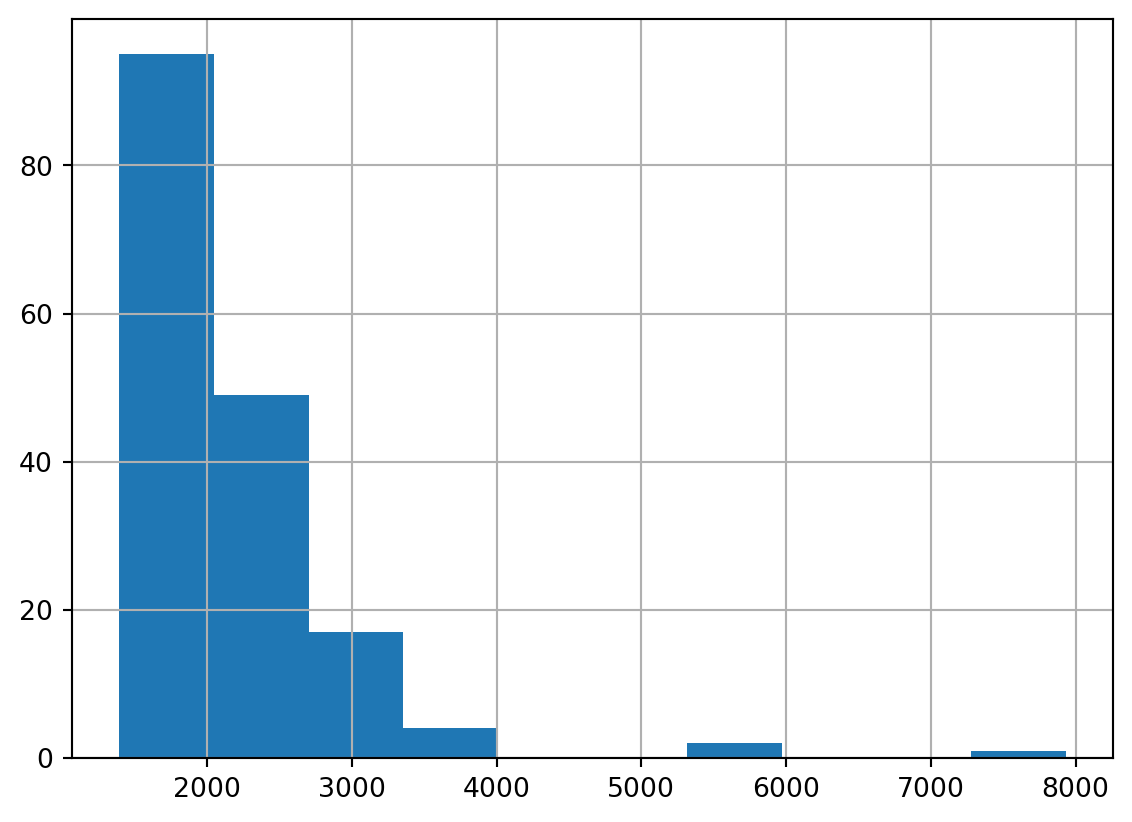

In [12]:
df['total_votes'].hist()

A log transformation can make this data closer to a gaussian distributed data variable. For the log transformation we are going to use `log2` method provided by `numpy` (numerical python), which is a rather excellent library.

In [13]:
import numpy as np

df['total_votes_log'] = np.log2(df['total_votes'])

<Axes: >

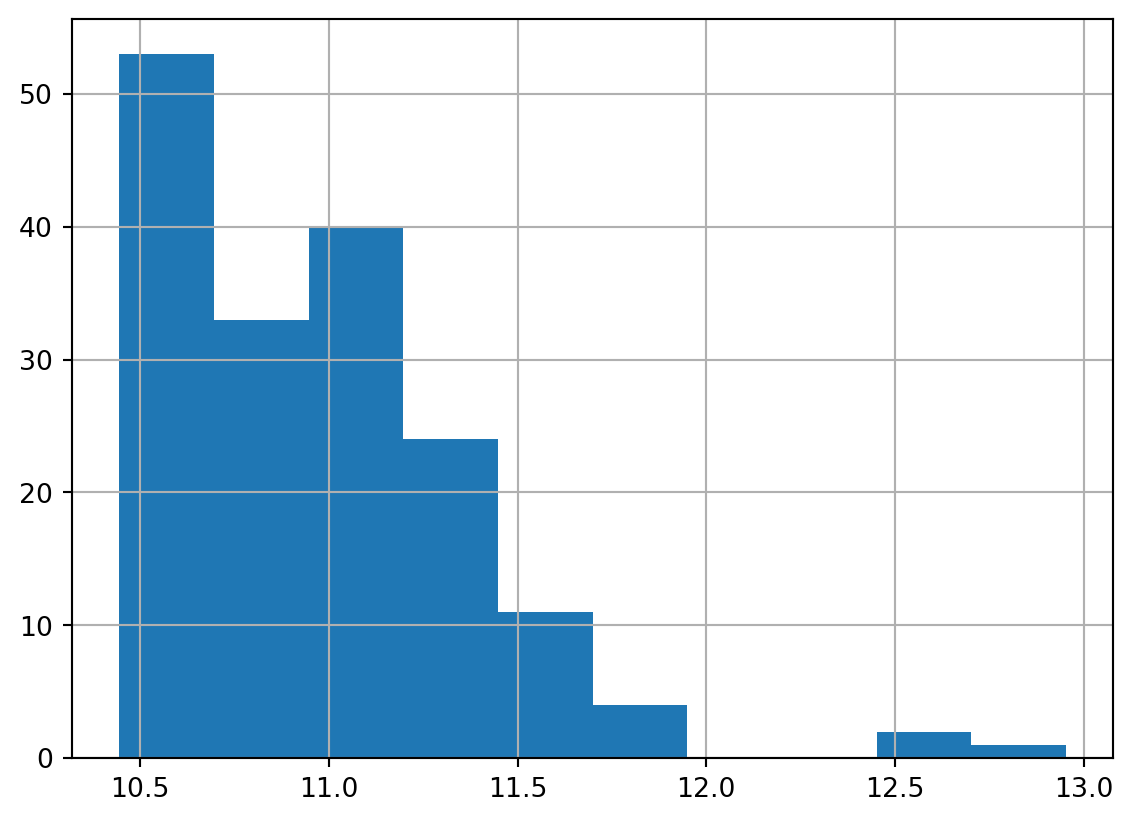

In [14]:
df['total_votes_log'].hist()

That is less skewed, but not ideal. Perhaps a _square root_ transformation instead?

<Axes: >

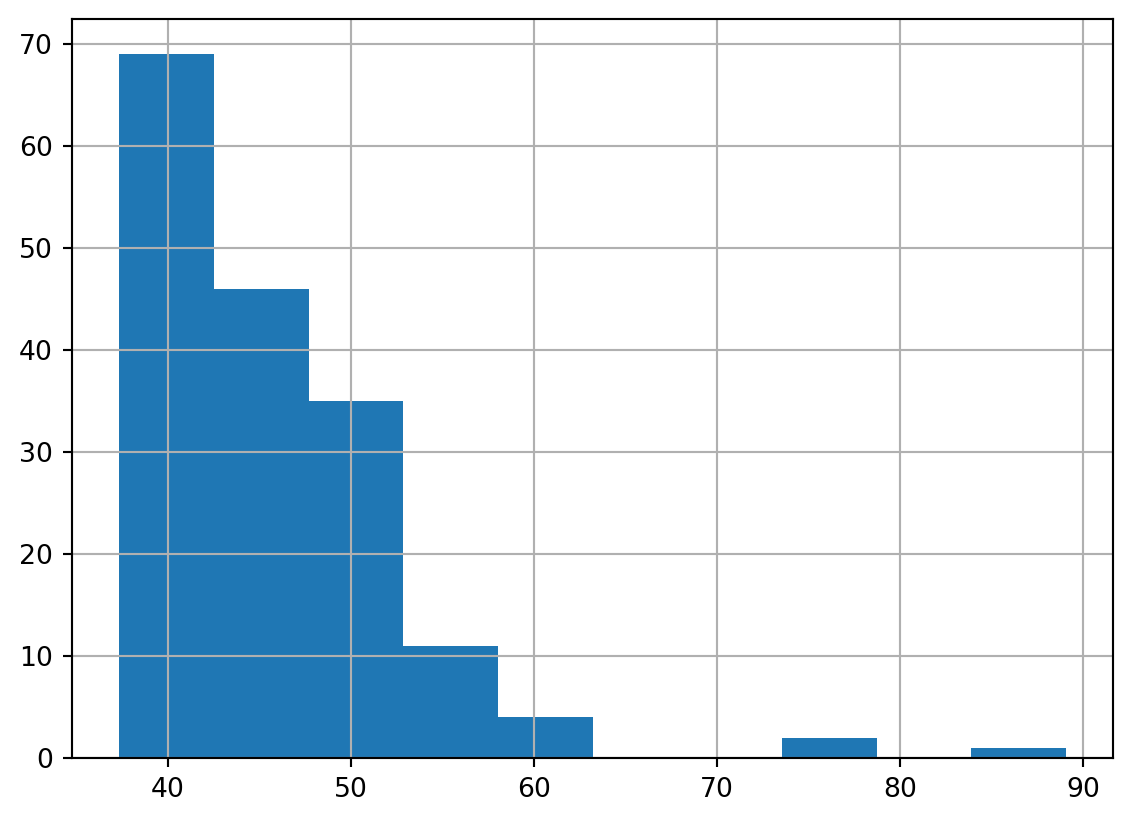

In [15]:
df['total_votes_sqrt'] = np.sqrt(df['total_votes'])
df['total_votes_sqrt'].hist()

...well, maybe a inverse/reciprocal transformation. It is possible we have hit the limit on what we can do.

<Axes: >

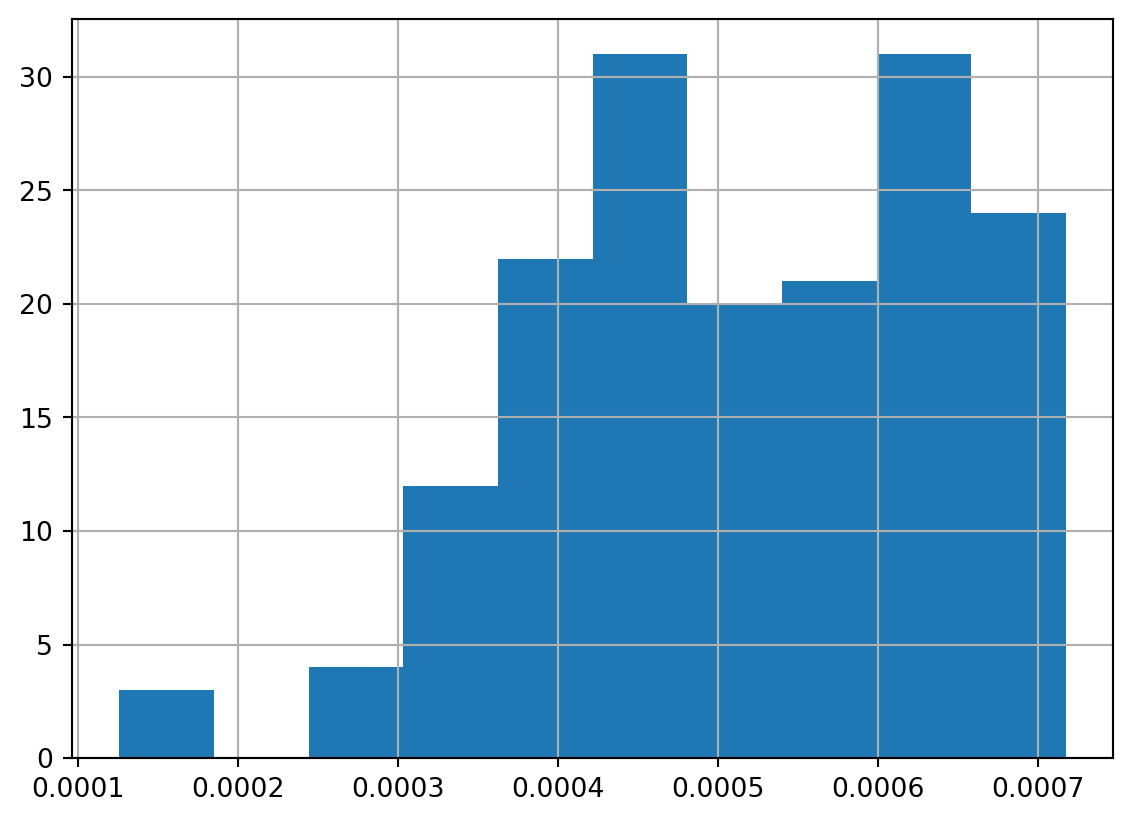

In [16]:
df['total_votes_recip'] = np.reciprocal(df['total_votes'])
df['total_votes_recip'].hist()

At this point, I think we should conceded that we can make the distribution less positively skewed. However, transformation are not magic and we cannot turn a heavily positively skewed distribution into a normally distributed one.

Oh well.

We can calculate `z` scores though so we can plot both `total_votes` and `imdb_ratings` on a single plot. Currently, the IMDB scores vary between 0 and 10 whereas the number of votes number in the thousands.

In [17]:
df['total_votes_z'] = (df['total_votes'] - df['total_votes'].mean()) / df['total_votes'].std()
df['imdb_rating_z'] = (df['imdb_rating'] - df['imdb_rating'].mean()) / df['imdb_rating'].std()

<Axes: >

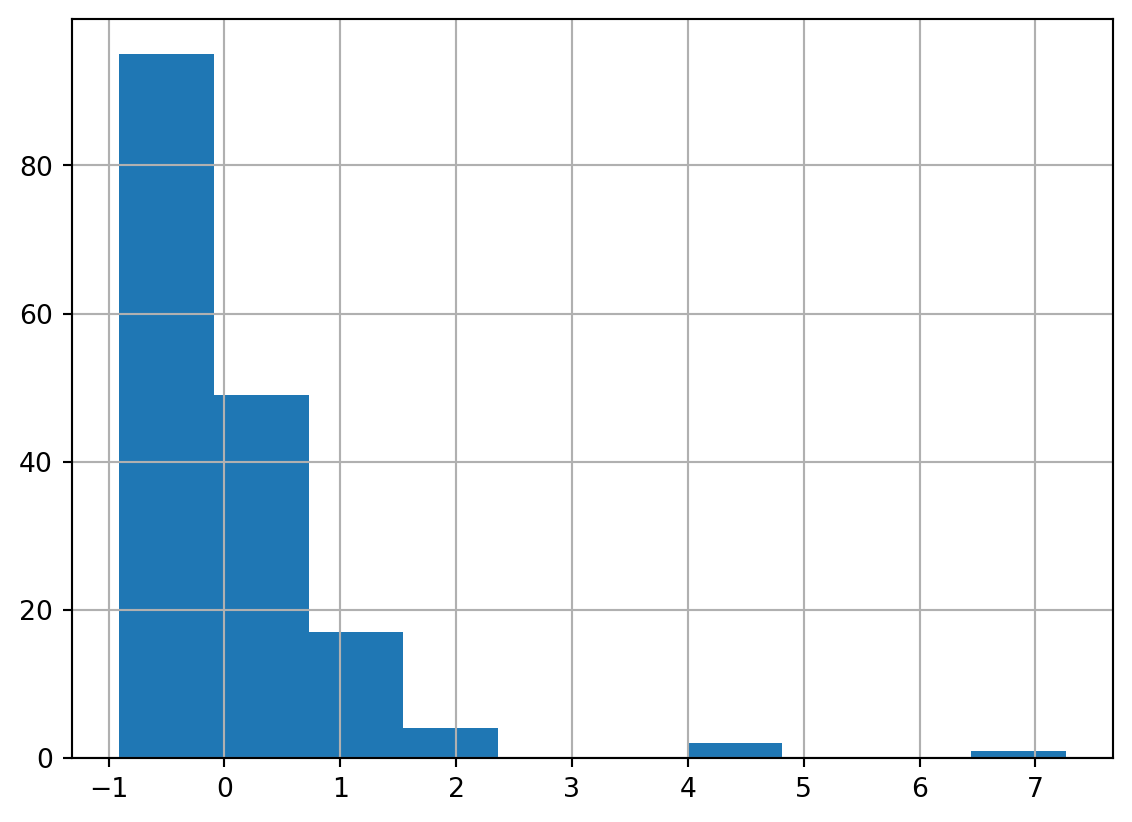

In [18]:
df['total_votes_z'].hist()

<Axes: >

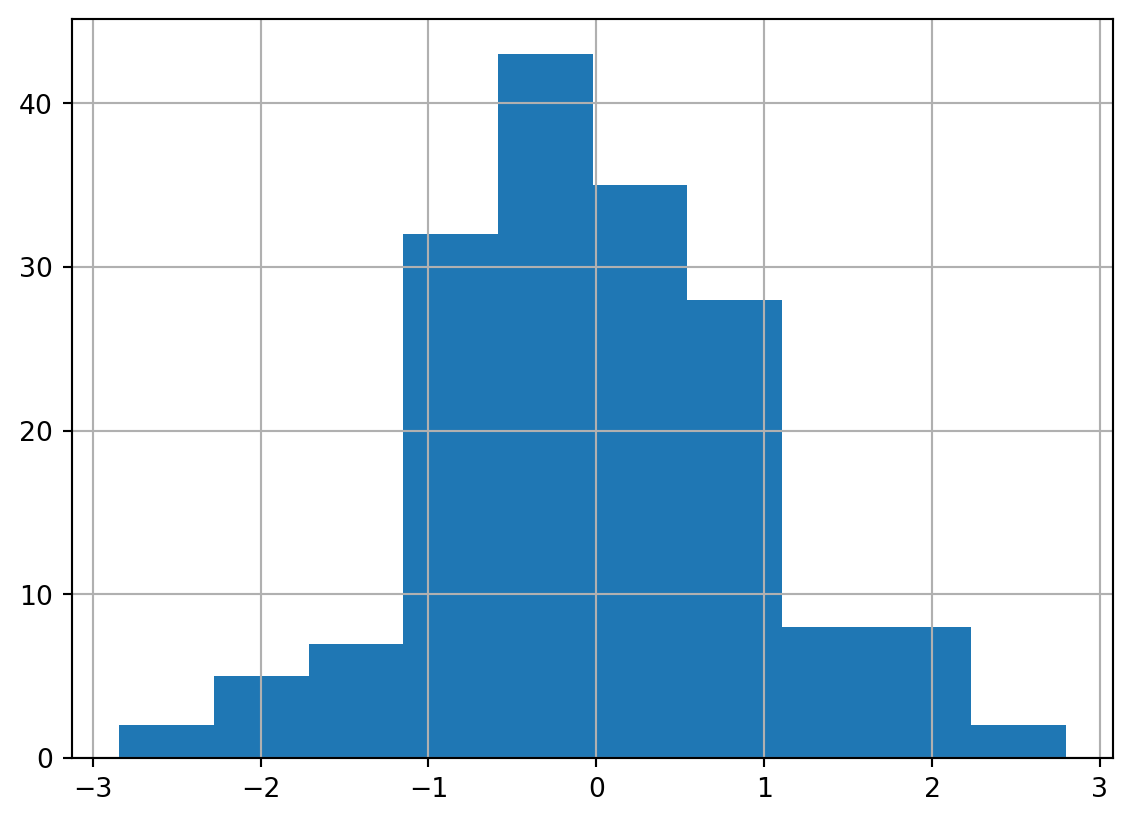

In [19]:
df['imdb_rating_z'].hist()

Now we can compare the trends in score and number of votes on a single plot.

::: callout-warning
We are going to use a slightly different approach to creating the plots. Called to the `plot()` method from Pandas actually use a library called `matplotlib`. We are going to use the `pyplot` module of `matplotlib` directly.
:::

In [20]:
import matplotlib.pyplot as plt

Convert the `air_date` into a datetime object.

In [21]:
df['air_date'] =  pd.to_datetime(df['air_date'], dayfirst=True)

Then call the subplots function fom pyplot to create two plots. From this we take the two plot axis (`ax1`, `ax2`) and call the method `scatter` for each to plot `imdb_rating_z` and `total_votes_z`.

Text(0.5, 1.0, 'Total votes')

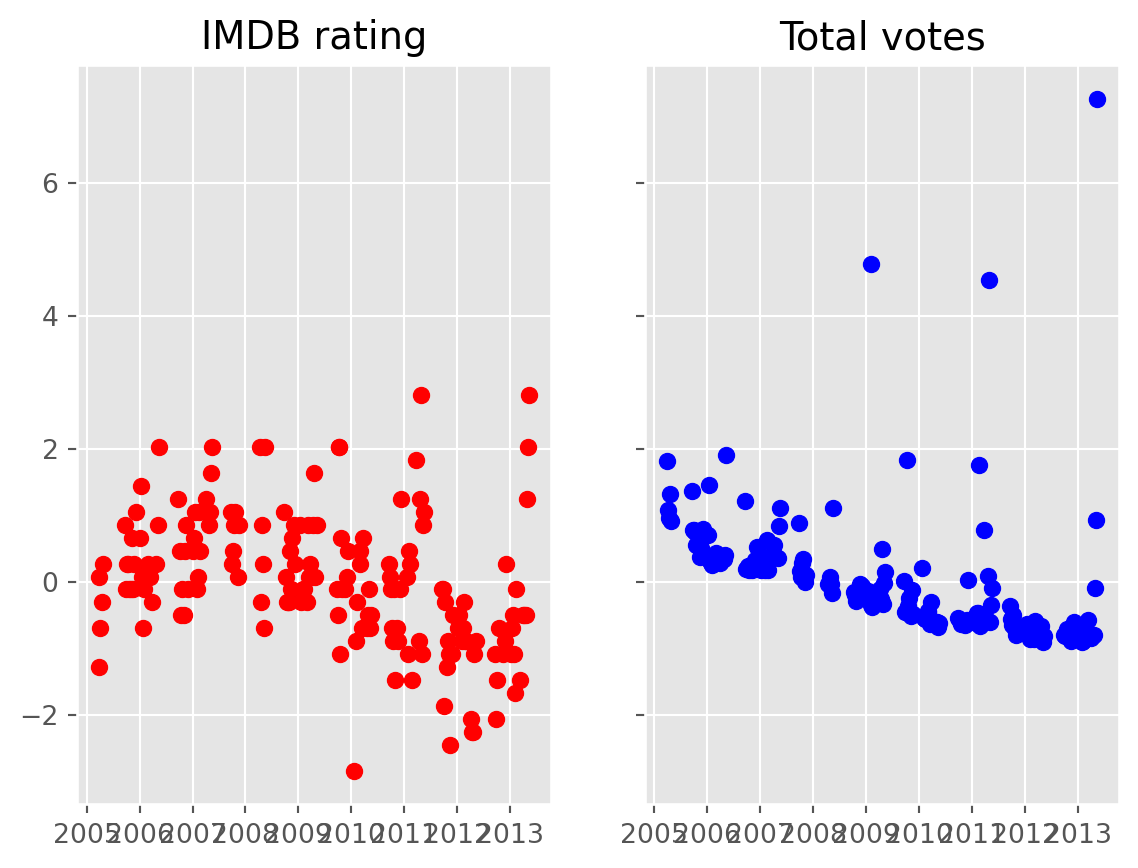

In [22]:
plt.style.use('ggplot')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter( df['air_date'], df['imdb_rating_z'], color = 'red')
ax1.set_title('IMDB rating')
ax2.scatter( df['air_date'], df['total_votes_z'], color = 'blue')
ax2.set_title('Total votes')

We can do better than that.

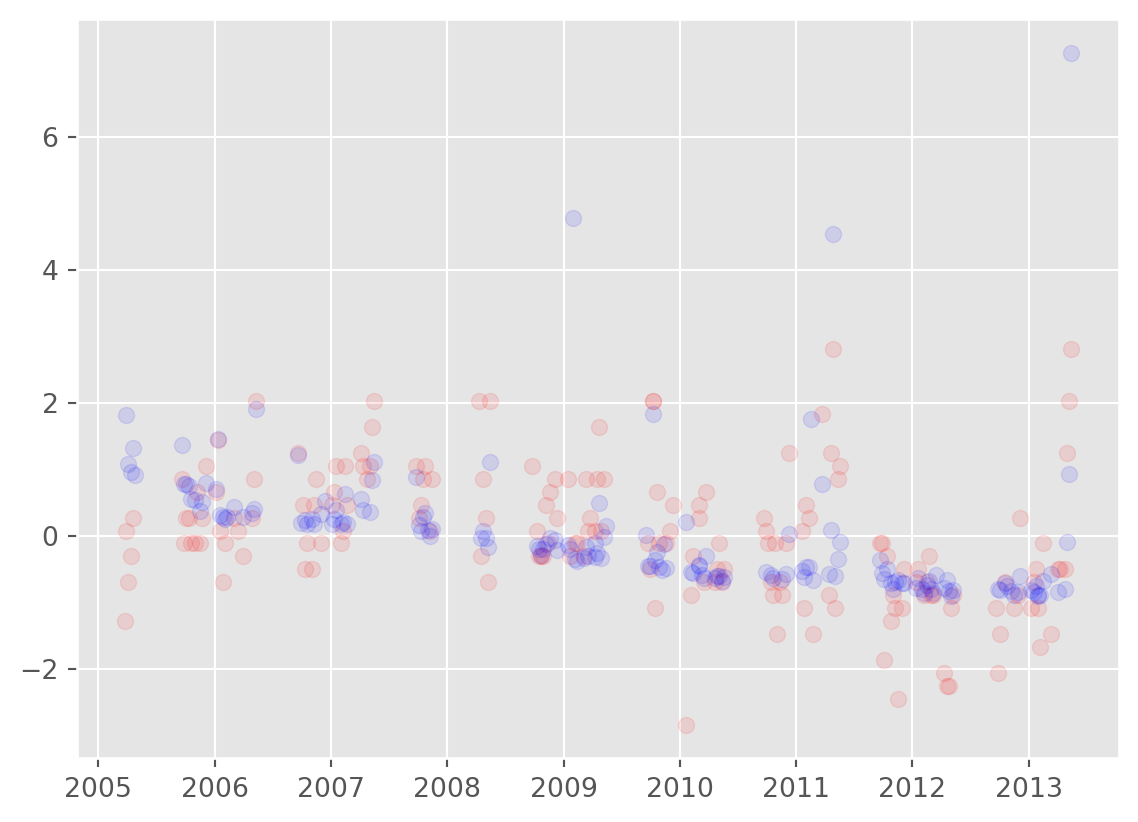

In [23]:
plt.scatter(df['air_date'], df['imdb_rating_z'], color = 'red', alpha = 0.1)
plt.scatter(df['air_date'], df['total_votes_z'], color = 'blue', alpha = 0.1)

We have done a lot so far. Exploring data in part 1, plotting data with the inbuilt Pandas methods in part 2 and dealing with both missing data and transfromations in part 3.

In part 4, we will look at creating your own functions, a plotting library called seaborn and introduce a larger dataset.